# Sea surface height wavenumber spectra in boxes

* __context__ : in preparation of indicator 3 of CMEMS project
* __purpose__ : compute slope of ssh wavenumber spectra in 10°x10° boxes
* __source__: notebook by JLS https://github.com/lesommer/private_notebooks/blob/master/2017/2017-01-14-jls-ssh-wavenumber-spectrum-NATL60-CJM165.ipynb

## 0. Required preliminary installations

    conda install numpy
    conda install dask
    conda install xarray
    pip install version_information
    git clone https://github.com/lesommer/codes.git
    cd codes
    ./install_modules.sh


In [1]:
# update pythonpath for jupyter

import sys
print(sys.path)
sys.path.insert(0,"/home/albert/lib/python")


['', '/home/albert/anaconda2/lib/python2.7/site-packages/oocgcm-0.1.0-py2.7.egg', '/home/albert/anaconda2/lib/python2.7/site-packages/numpy-1.11.1-py2.7-linux-x86_64.egg', '/home/albert/anaconda2/lib/python27.zip', '/home/albert/anaconda2/lib/python2.7', '/home/albert/anaconda2/lib/python2.7/plat-linux2', '/home/albert/anaconda2/lib/python2.7/lib-tk', '/home/albert/anaconda2/lib/python2.7/lib-old', '/home/albert/anaconda2/lib/python2.7/lib-dynload', '/home/albert/anaconda2/lib/python2.7/site-packages', '/home/albert/anaconda2/lib/python2.7/site-packages/Sphinx-1.4.1-py2.7.egg', '/home/albert/anaconda2/lib/python2.7/site-packages/colormap-0.9.8-py2.7.egg', '/home/albert/anaconda2/lib/python2.7/site-packages/setuptools-23.0.0-py2.7.egg', '/home/albert/anaconda2/lib/python2.7/site-packages/IPython/extensions', '/home/albert/.ipython']


## 1. Modules, datasets and parameters

In [2]:
#- Essential modules 
import numpy as np
import dask 
import xarray as xr
import GriddedData
import time
from netCDF4 import Dataset

In [3]:
#- Other modules
import os
from glob import glob
import numpy.ma as ma
import scipy as sc
### palette
import matplotlib.cm as mplcm
import matplotlib.ticker as mticker
import colormap as cmaps
import matplotlib.cm as cm
#cm.register_cmap(name='viridis', cmap=cmaps.viridis)
import seaborn as sns
#seq_cmap = cmaps.viridis # future default matplotlib
#div_cmap = mplcm.seismic
### quick plot
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
%config InlineBackend.figure_format = 'retina'

In [5]:
database = "/home/albert/Data/NATL60/NATL60-CJM165-S/"
file_ssh_mar = database + 'NATL60-CJM165_y2013m03.1d.gridTsurf.nc'
file_ssh_sep = database + 'NATL60-CJM165_y2012m09.1d.gridTsurf.nc' 
file_ssh_sep13 = database + 'NATL60-CJM165_y2013m09.1d.gridTsurf.nc' 
file_hgrid = "/home/albert/Data/NATL60/NATL60-I/NATL60_coordinates_v4.nc"
file_bmask = "/home/albert/Data/NATL60/NATL60-I/NATL60_v4.1_cdf_byte_mask.nc"

In [6]:
file_ssh_mar

'/home/albert/Data/NATL60/NATL60-CJM165-S/NATL60-CJM165_y2013m03.1d.gridTsurf.nc'

## 2. Testing wavenumber computation from array

In [7]:
import WavenumberSpectrum as ws

In [8]:
ds_mar = xr.open_mfdataset(file_ssh_mar,engine='netcdf4',lock=False)
ds_sep = xr.open_mfdataset(file_ssh_sep,engine='netcdf4',lock=False)
ds_sep13 = xr.open_mfdataset(file_ssh_sep13,engine='netcdf4',lock=False)
ssh_da_sep = ds_sep["sossheig"]
ssh_da_sep13 = ds_sep13["sossheig"]
ssh_da_mar = ds_mar["sossheig"]

In [9]:
ds = ds_mar
navlon = np.array(ds["nav_lon"][:].squeeze())
navlat = np.array(ds["nav_lat"][:].squeeze())
print ds["nav_lon"].shape

(3454, 5422)


In [10]:
ssh_da = ssh_da_mar

In [11]:
#%pdb on
#- compute the wavenumber spectrum
interp = 'basemap'

def compute_spectrum(var_da,navlon,navlat,itmin=0,itmax=1,verbose=False):
    l_pspec = []
    for it in np.arange(itmin,itmax):
        if verbose: print('processing time it = ' + str(it))
        data = np.array(var_da[it])
        x_reg,y_reg,data_reg = ws.interpolate(data,navlon,navlat,interp=interp)
        pspec,kstep = ws.get_spectrum_1d(data_reg,x_reg,y_reg)
        l_pspec.append(pspec)
    a_pspec = np.array(l_pspec) 
    m_pspec = a_pspec.mean(axis=0) # mean spectrum
    return m_pspec, kstep

zlon = navlon[1000:1500,3000:3500]
zlat = navlat[1000:1500,3000:3500]
zssh = ssh_da[:,1000:1500,3000:3500]

%time pspec, kstep = compute_spectrum(zssh,zlon,zlat,itmin=0,itmax=10,verbose=True)

processing time it = 0
processing time it = 1
processing time it = 2
processing time it = 3
processing time it = 4
processing time it = 5
processing time it = 6
processing time it = 7
processing time it = 8
processing time it = 9
CPU times: user 11.2 s, sys: 164 ms, total: 11.4 s
Wall time: 11.6 s


legend test
estimated slope :  -4.6


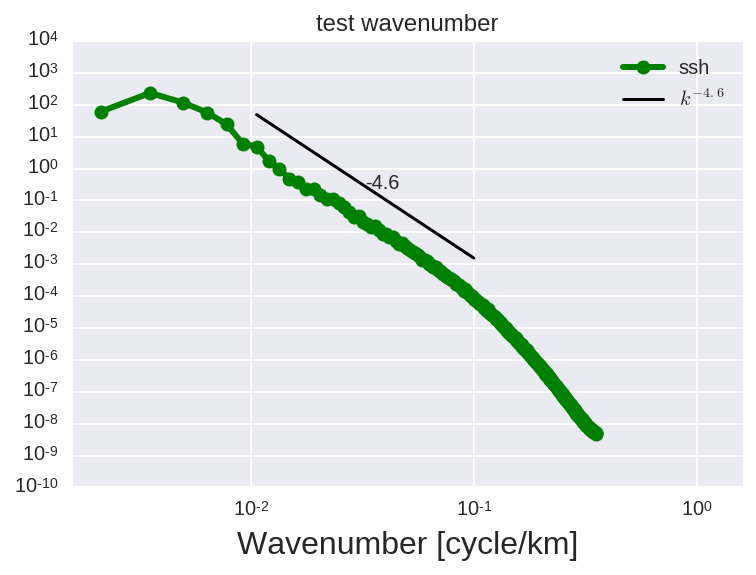

In [12]:
#- plot the mean spectrum 

pdic = {}
pdic['varname'] = 'ssh'
pdic['title'] = 'test wavenumber'
pdic['legend'] = 'test'
pdic['klines'] = None
pdic['kfit'] = None
pdic['plotname'] = None
pdic['kfit'] = True
pdic['klmin'] = 10.
pdic['klmax'] = 100.


ws.plot_spectrum(pspec,kstep,**pdic)
#ax.set_ybound(0.000000001,10000)

## 3. Defining the boxes

In [13]:
datagrid =xr.open_mfdataset(file_hgrid,engine='netcdf4',lock=False)
maskgrid =xr.open_mfdataset(file_bmask,engine='netcdf4',lock=False)
_navlat = np.array(datagrid.variables['nav_lat'])
_navlon = np.array(datagrid.variables['nav_lon'])
_tmask = np.array(maskgrid.variables['tmask'][0,0])==0
_tmask.shape

(3454, 5422)

In [14]:
#- define the coarsener
boxsize = 400
x_offset = 0
y_offset = 100
grd = GriddedData.grid2D(navlat=_navlat,navlon=_navlon)
crs = GriddedData.grdCoarsener(grd,x_offset=x_offset,y_offset=y_offset,crs_factor=boxsize)


In [15]:
#- deep ravelled lat, lon
navlat_dr = crs.return_deep_ravel(_navlat)
navlon_dr = crs.return_deep_ravel(_navlon)

In [16]:
lonmins = navlon_dr.min(axis=(-1,-2))
lonmaxs = navlon_dr.max(axis=(-1,-2))
latmins = navlat_dr.min(axis=(-1,-2))
latmaxs = navlat_dr.max(axis=(-1,-2))

In [17]:
jpj,jpi = navlon.shape
i_indices = np.arange(jpi).repeat(jpj).reshape((jpi,jpj)).transpose()
j_indices = np.arange(jpj).repeat(jpi).reshape((jpj,jpi))


In [18]:
jpj,jpi

(3454, 5422)

In [19]:
i_indices_dr = crs.return_deep_ravel(i_indices)
j_indices_dr = crs.return_deep_ravel(j_indices)

imins = i_indices_dr.min(axis=(-1,-2))
imaxs = i_indices_dr.max(axis=(-1,-2))
jmins = j_indices_dr.min(axis=(-1,-2))
jmaxs = j_indices_dr.max(axis=(-1,-2))

In [20]:
#- defining the boxes
class box: # empty container. 
    def __init__(self,name=None):
        self.name = name
        return

dictboxes = {}

for ibox,(lonmin,lonmax,latmin,latmax) in enumerate(zip(lonmins,lonmaxs,latmins,latmaxs)):
    abox = box(str(ibox))
    abox.lonmin = lonmin
    abox.lonmax = lonmax
    abox.latmin = latmin
    abox.latmax = latmax
    abox.navlon = navlon_dr[ibox].squeeze()
    abox.navlat = navlat_dr[ibox].squeeze()  
    abox.imin = imins[ibox]
    abox.imax = imaxs[ibox]
    abox.jmin = jmins[ibox]
    abox.jmax = jmaxs[ibox]    
    dictboxes[str(ibox)] = abox   

# test box

tbox = box('TEST')
tbox.lonmin = -40
tbox.lonmax = -38.
tbox.latmin = 30
tbox.latmax = 32

boxes = dictboxes.values()

In [21]:
#- tool for plotting
# sources : 
# http://scitools.org.uk/cartopy/docs/latest/matplotlib/intro.html

transform = ccrs.PlateCarree()

pltargs = {
   'transform' : transform,
   'color' : 'black',
   'linewidth' : 2}

def plot_individual_box(box,ax=None):
    x1 = box.lonmin 
    x2 = box.lonmax
    y1 = box.latmin 
    y2 = box.latmax 
    ax.plot([x1, x2], [y1, y1],**pltargs)
    ax.plot([x1, x2], [y2, y2],**pltargs)
    ax.plot([x1, x1], [y1, y2],**pltargs)
    ax.plot([x2, x2], [y1, y2],**pltargs)
    ax.text(x1+0.25,y2-1.25,box.name)
    

def plot_boxes(boxlist,textbox=None,title=None):
    plt.figure(figsize=(15,10))
    proj = transform
    ax = plt.axes(projection=proj)
    ax.stock_img()
    for box in boxlist:
        plot_individual_box(box,ax=ax)
    ax.coastlines(resolution="10m")
    
    # grid lines
    gl = ax.gridlines(crs=proj, draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')

    label_style = {'size': 12, 'color': 'black', 'weight': 'bold'}

    gl.xlabel_style = label_style
    gl.xlabels_bottom = False
    gl.xlocator = mticker.FixedLocator(np.arange(-90,10,5,dtype=float))

    gl.ylabel_style = label_style
    gl.ylabels_right = False
    gl.ylocator = mticker.FixedLocator(np.arange(20,80,5,dtype=float))
    
    
    #ax.grid(False)
    plt.xlim((-85,5))
    plt.ylim((25,70))
    if textbox is not None:
        # see http://matplotlib.org/users/annotations_guide.html
        props = dict(boxstyle='round', facecolor='white', alpha=1., edgecolor="black", lw=2)
        ax.text(0.05, 0.10, textbox, transform=ax.transAxes, fontsize=18,verticalalignment='top',bbox=props)
    if title is not None:
        plt.title(title,fontsize=20,y=1.08)

/home/albert/anaconda2/lib/python2.7/site-packages/cartopy/io/__init__.py:264: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/10m/physical/ne_10m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


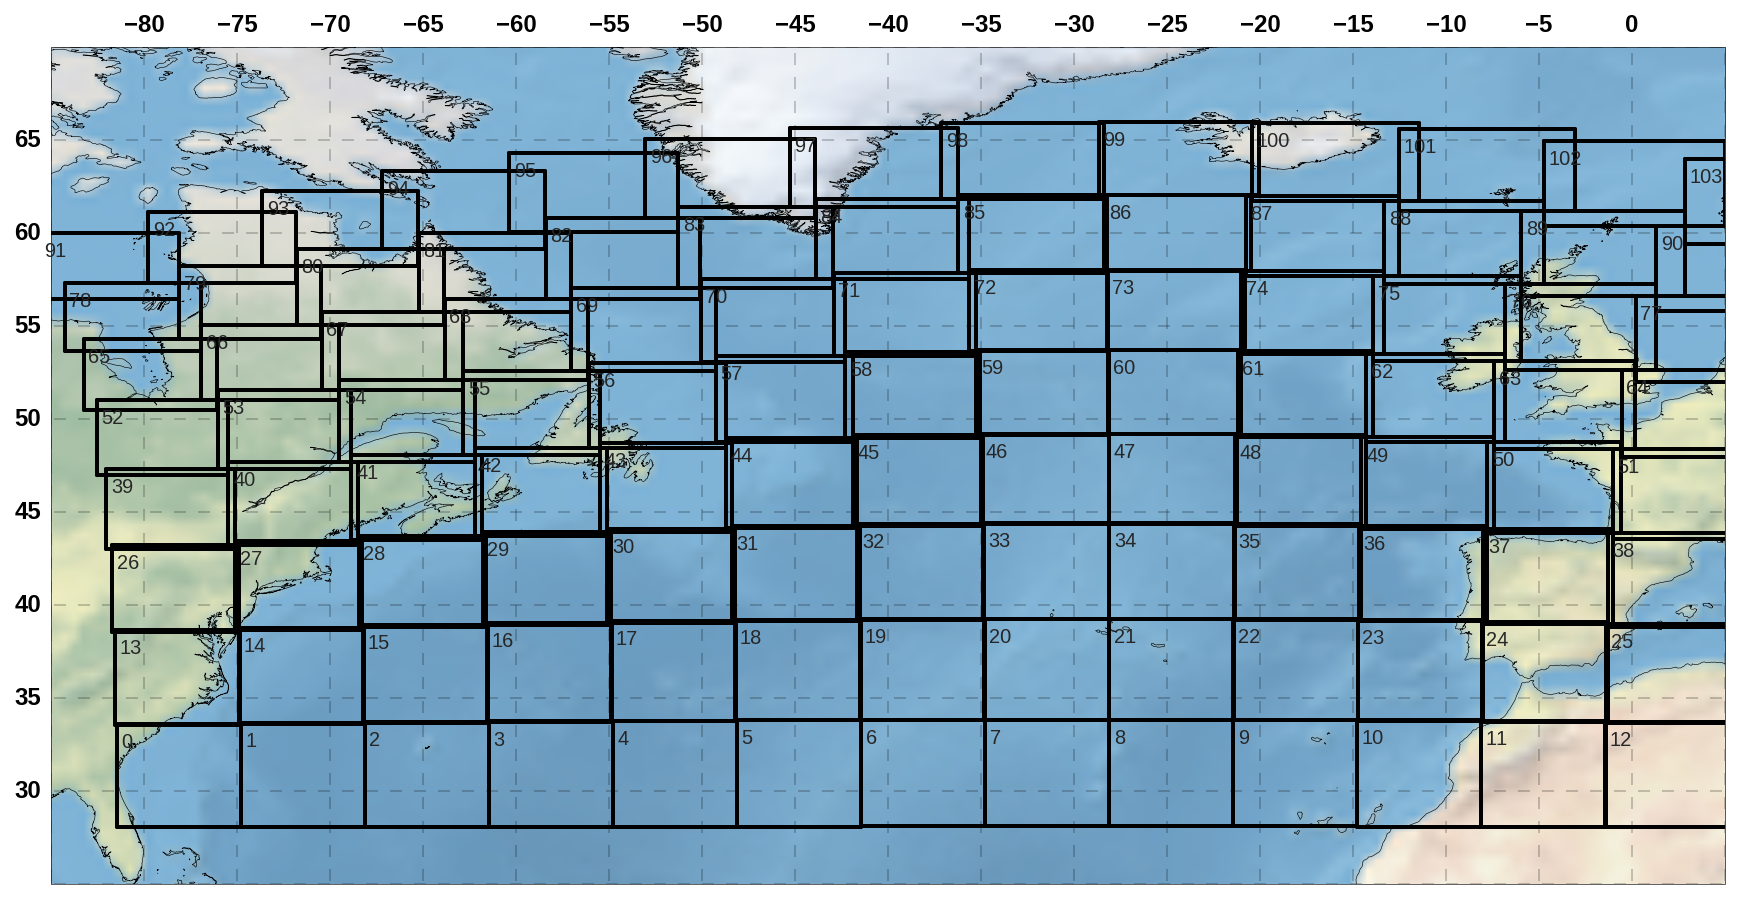

In [22]:
plot_boxes(boxes)

In [23]:
rmask = crs.return_deep_ravel(_tmask).sum(axis=(-1,-2))
np.where(rmask==0)[0]

array([ 1,  3,  4,  5,  6,  7,  8, 14, 15, 16, 17, 18, 19, 22, 29, 30, 31,
       32, 34, 35, 44, 45, 46, 47, 48, 49, 57, 58, 59, 60, 61, 70, 71, 72,
       73, 74, 82, 85, 86, 87, 95])

In [24]:
#- removing boxes

rmask = crs.return_deep_ravel(_tmask).sum(axis=(-1,-2))
boxes_to_remove = np.where(rmask!=0)[0]


def remove_boxes(dictboxes,boxes_to_remove):
    r = dict(dictboxes) # shallow copy
    for boxname in boxes_to_remove:
        del r[str(boxname)]
    return r

    
#boxes_to_remove = [36,18,27,34,43,44,35,26,17,7,8,28,37,9,19,29,39,40,38,25,16,20,6,14]    
rboxes = remove_boxes(dictboxes,boxes_to_remove).values()

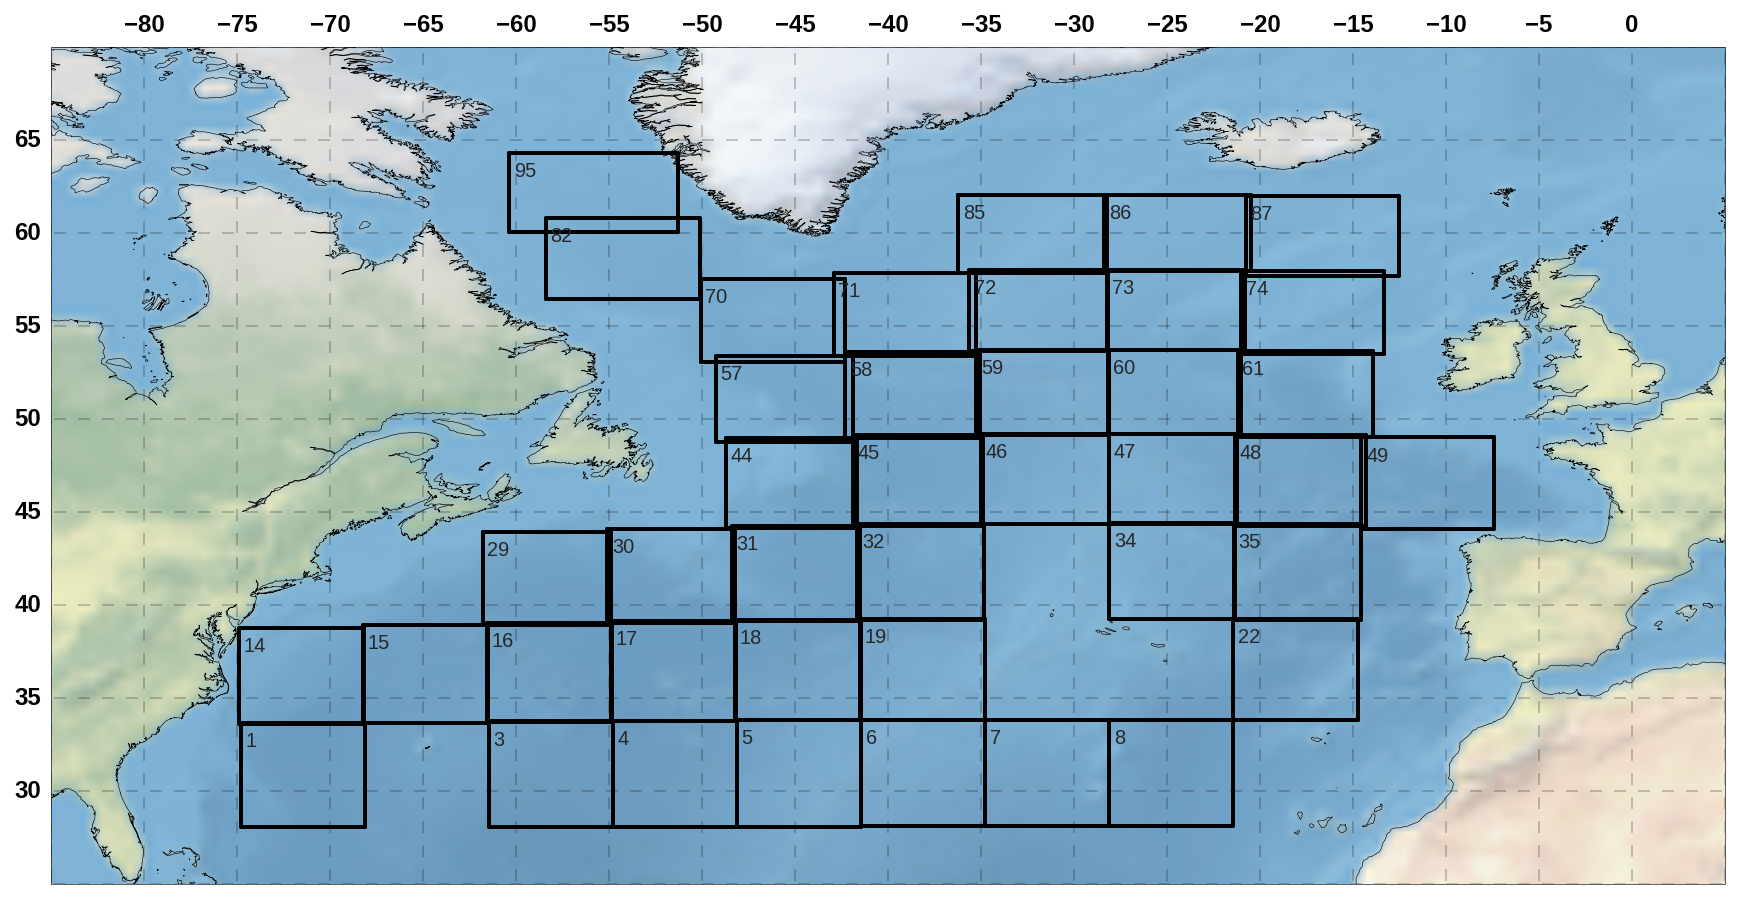

In [25]:
plot_boxes(rboxes)

In [26]:
def plot_boxes_attribute(boxes,attr='name',title=None,**kwargs):
    plt.figure(figsize=(15,10))
    proj = transform
    ax = plt.axes(projection=proj)
    ax.stock_img()
    for box in boxes:
        x1 = box.lonmin 
        x2 = box.lonmax
        y1 = box.latmin 
        y2 = box.latmax 
        if hasattr(box,attr):
           ax.text((x1+x2)/2.-0.25,(y1+y2)/2.-0.25,str(eval('box.' + attr)),**kwargs)        
    ax.coastlines(resolution="10m")

    # grid lines
    gl = ax.gridlines(crs=proj, draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')

    label_style = {'size': 12, 'color': 'black', 'weight': 'bold'}

    gl.xlabel_style = label_style
    gl.xlabels_bottom = False
    #gl.xlocator = mticker.FixedLocator(np.arange(-90,10,5,dtype=float))

    gl.ylabel_style = label_style
    gl.ylabels_right = False
    #gl.ylocator = mticker.FixedLocator(np.arange(20,80,5,dtype=float))
  
    # grid lines

    #gl = ax.gridlines(draw_labels=True)
    gl.xlines = False
    gl.ylines = False

    plt.xlim((-85,5))
    plt.ylim((25,70))  
    if title is not None:
        plt.title(title,fontsize=20,y=1.08)

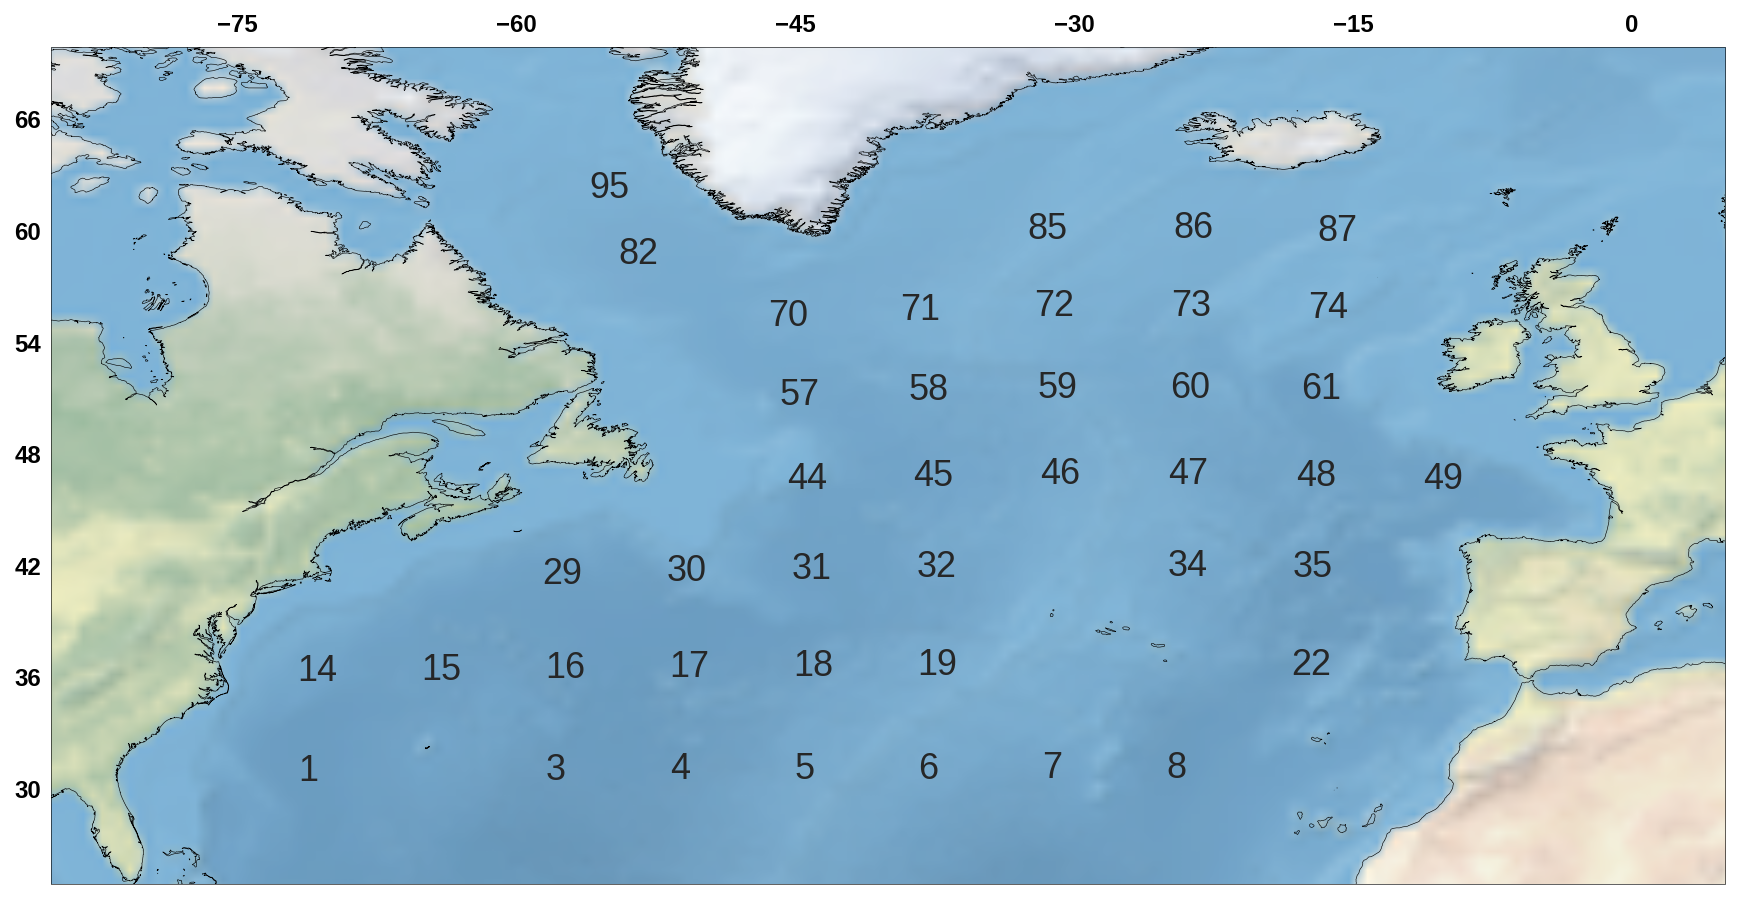

In [27]:
plot_boxes_attribute(rboxes,fontsize=18)

## Core computation, looping on the boxes

In [28]:
def get_ssh_da_in_box(box,mth='mar'):
    ibox = int(box.name)
    jmin,jmax = box.jmin,box.jmax
    imin,imax = box.imin,box.imax   
    if mth=='mar':
       ssh = ssh_da_mar[:,jmin:jmax+1,imin:imax+1]
    elif mth=='sep':
       ssh = ssh_da_sep[:,jmin:jmax+1,imin:imax+1]
    elif mth=='sep13':
       ssh = ssh_da_sep13[:,jmin:jmax+1,imin:imax+1]   
    return ssh
    
def compute_power_spectrum_for_box(box,mth='mar'):
    sshbox = get_ssh_da_in_box(box,mth=mth)
    if mth=='mar':
       box.ssh_power_spectrum_mar = compute_spectrum(sshbox,box.navlon,box.navlat,itmin=0,itmax=31,verbose=False)
    elif mth=='sep':
       box.ssh_power_spectrum_sep = compute_spectrum(sshbox,box.navlon,box.navlat,itmin=0,itmax=30,verbose=False)
    elif mth=='sep13':
       box.ssh_power_spectrum_sep13 = compute_spectrum(sshbox,box.navlon,box.navlat,itmin=0,itmax=30,verbose=False)
 
    
def compute_power_spectrum_for_boxes(boxes,mth='mar'):
    for box in boxes:
        print('processing box ' +  box.name)
        compute_power_spectrum_for_box(box,mth=mth)

#ssh = get_ssh_da_in_box(boxes[1])

In [29]:
np.all(navlon[boxes[1].jmin:boxes[1].jmax+1,boxes[1].imin:boxes[1].imax+1]==boxes[1].navlon) *\
np.all(navlat[boxes[1].jmin:boxes[1].jmax+1,boxes[1].imin:boxes[1].imax+1]==boxes[1].navlat)

True

In [30]:
%pdb off

Automatic pdb calling has been turned OFF


In [31]:
compute_power_spectrum_for_boxes(rboxes,mth='mar')

processing box 60
processing box 61
processing box 22
processing box 29
processing box 4
processing box 6
processing box 8
processing box 95
processing box 59
processing box 58
processing box 17
processing box 16
processing box 57
processing box 19
processing box 18
processing box 15
processing box 82
processing box 86
processing box 87
processing box 85
processing box 48
processing box 49
processing box 46
processing box 47
processing box 44
processing box 45
processing box 1
processing box 3
processing box 5
processing box 7
processing box 74
processing box 73
processing box 72
processing box 71
processing box 70
processing box 14
processing box 32
processing box 31
processing box 30
processing box 35
processing box 34


In [32]:
compute_power_spectrum_for_boxes(rboxes,mth='sep')

processing box 60
processing box 61
processing box 22
processing box 29
processing box 4
processing box 6
processing box 8
processing box 95
processing box 59
processing box 58
processing box 17
processing box 16
processing box 57
processing box 19
processing box 18
processing box 15
processing box 82
processing box 86
processing box 87
processing box 85
processing box 48
processing box 49
processing box 46
processing box 47
processing box 44
processing box 45
processing box 1
processing box 3
processing box 5
processing box 7
processing box 74
processing box 73
processing box 72
processing box 71
processing box 70
processing box 14
processing box 32
processing box 31
processing box 30
processing box 35
processing box 34


In [33]:
compute_power_spectrum_for_boxes(rboxes,mth='sep13')

processing box 60
processing box 61
processing box 22
processing box 29
processing box 4
processing box 6
processing box 8
processing box 95
processing box 59
processing box 58
processing box 17
processing box 16
processing box 57
processing box 19
processing box 18
processing box 15
processing box 82
processing box 86
processing box 87
processing box 85
processing box 48
processing box 49
processing box 46
processing box 47
processing box 44
processing box 45
processing box 1
processing box 3
processing box 5
processing box 7
processing box 74
processing box 73
processing box 72
processing box 71
processing box 70
processing box 14
processing box 32
processing box 31
processing box 30
processing box 35
processing box 34


In [34]:
klmin = 10.  # 10km # 70
klmax = 100. # 100km # 250

kstepmin = ws.km2kstep(klmin)
kstepmax = ws.km2kstep(klmax)
rad2cyc = 1.E3 / np.pi / 2.  # CHECK ME : 2 pi or pi ?

for box in rboxes:
    pspec, kstep = box.ssh_power_spectrum_mar
    _kstep = kstep * rad2cyc
    kstep_r = _kstep[(_kstep<kstepmin)*(_kstep>kstepmax)]
    pspec_r = pspec[(_kstep<kstepmin)*(_kstep>kstepmax)]
    kval = ws.estimate_slope(pspec_r,kstep_r)
    kstr = "{:1.1f}".format(kval)
    box.ssh_slope_mar = kval
    box.str_ssh_slope_mar = kstr
    
for box in rboxes:
    pspec, kstep = box.ssh_power_spectrum_sep
    _kstep = kstep * rad2cyc
    kstep_r = _kstep[(_kstep<kstepmin)*(_kstep>kstepmax)]
    pspec_r = pspec[(_kstep<kstepmin)*(_kstep>kstepmax)]
    kval = ws.estimate_slope(pspec_r,kstep_r)
    kstr = "{:1.1f}".format(kval)
    box.ssh_slope_sep = kval
    box.str_ssh_slope_sep = kstr
   
for box in rboxes:
    pspec, kstep = box.ssh_power_spectrum_sep13
    _kstep = kstep * rad2cyc
    kstep_r = _kstep[(_kstep<kstepmin)*(_kstep>kstepmax)]
    pspec_r = pspec[(_kstep<kstepmin)*(_kstep>kstepmax)]
    kval = ws.estimate_slope(pspec_r,kstep_r)
    kstr = "{:1.1f}".format(kval)
    box.ssh_slope_sep13 = kval
    box.str_ssh_slope_sep13 = kstr


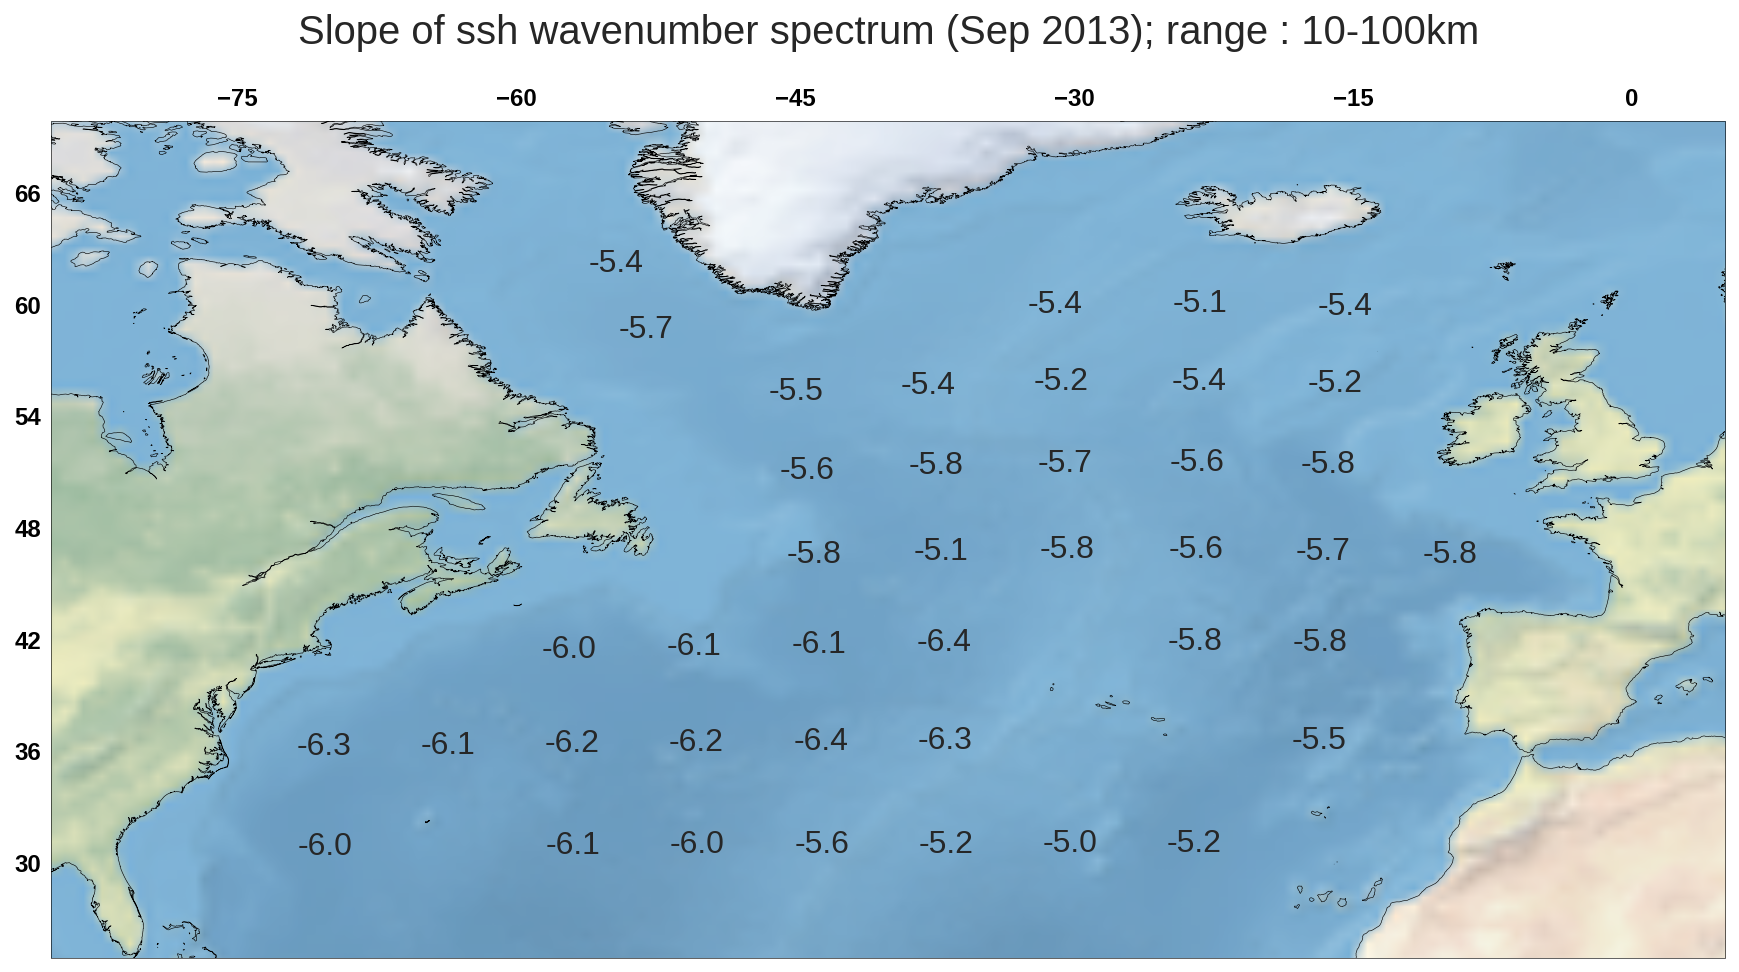

In [35]:
title = "Slope of ssh wavenumber spectrum (Sep 2013); range : 10-100km"
plot_boxes_attribute(rboxes,'str_ssh_slope_sep13',fontsize=16,title=title)


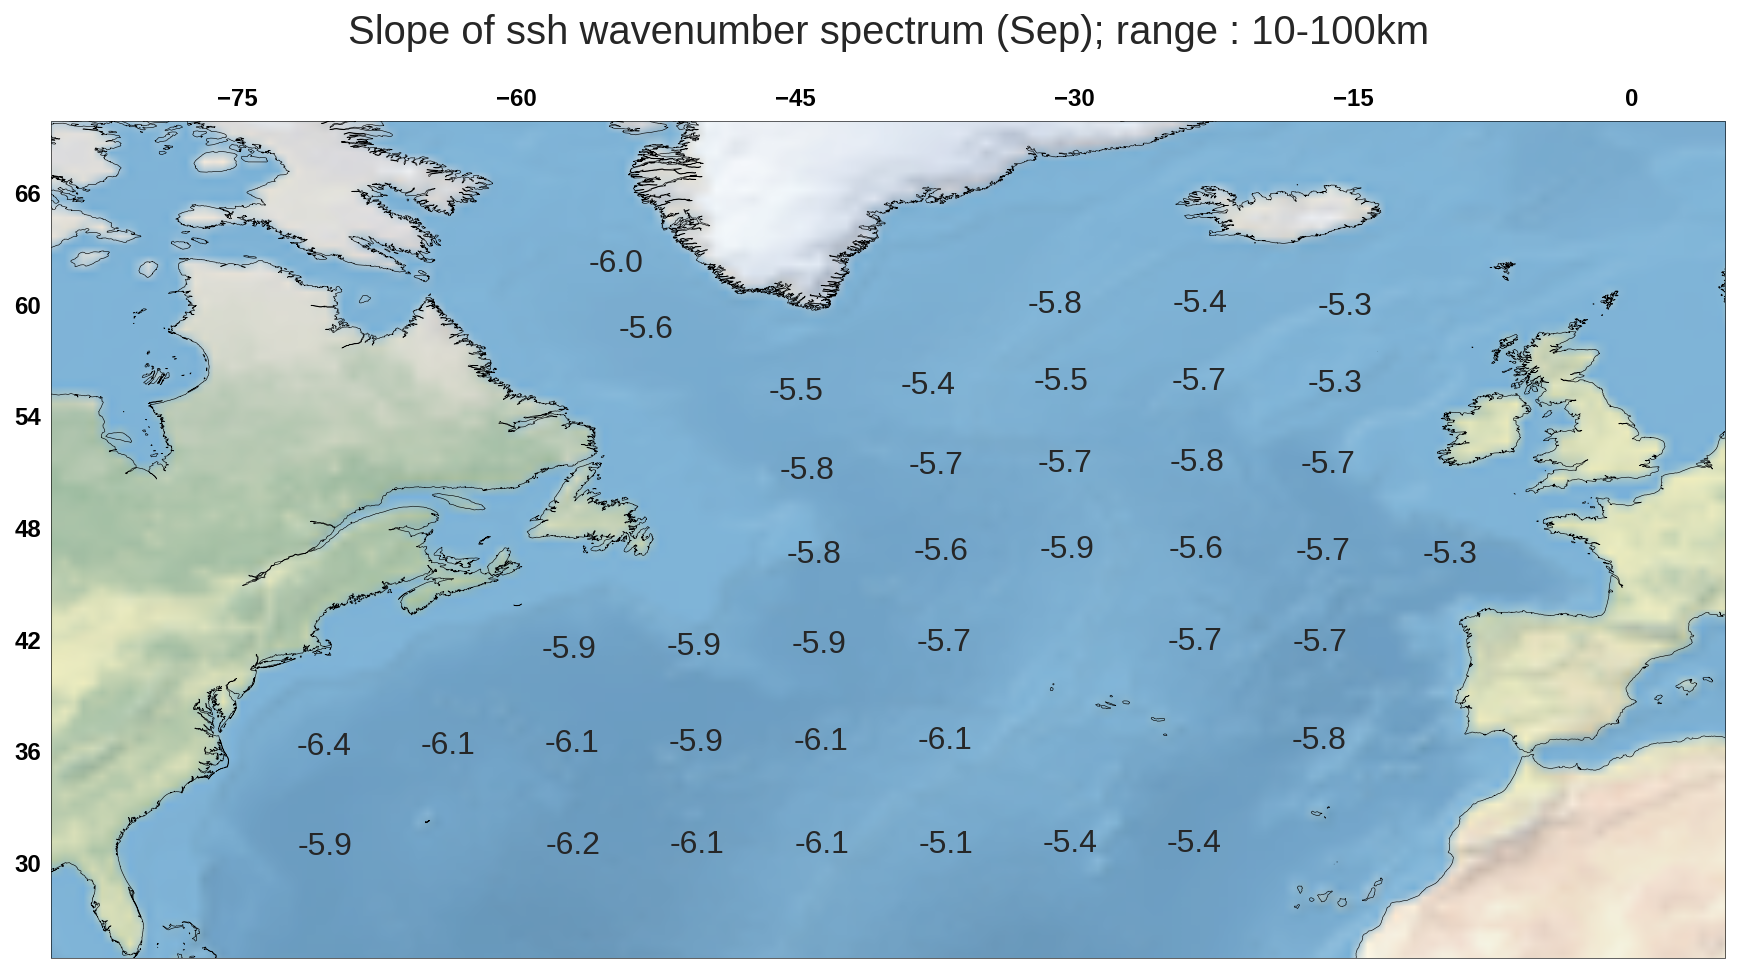

In [36]:
title = "Slope of ssh wavenumber spectrum (Sep); range : 10-100km"
plot_boxes_attribute(rboxes,'str_ssh_slope_sep',fontsize=16,title=title)


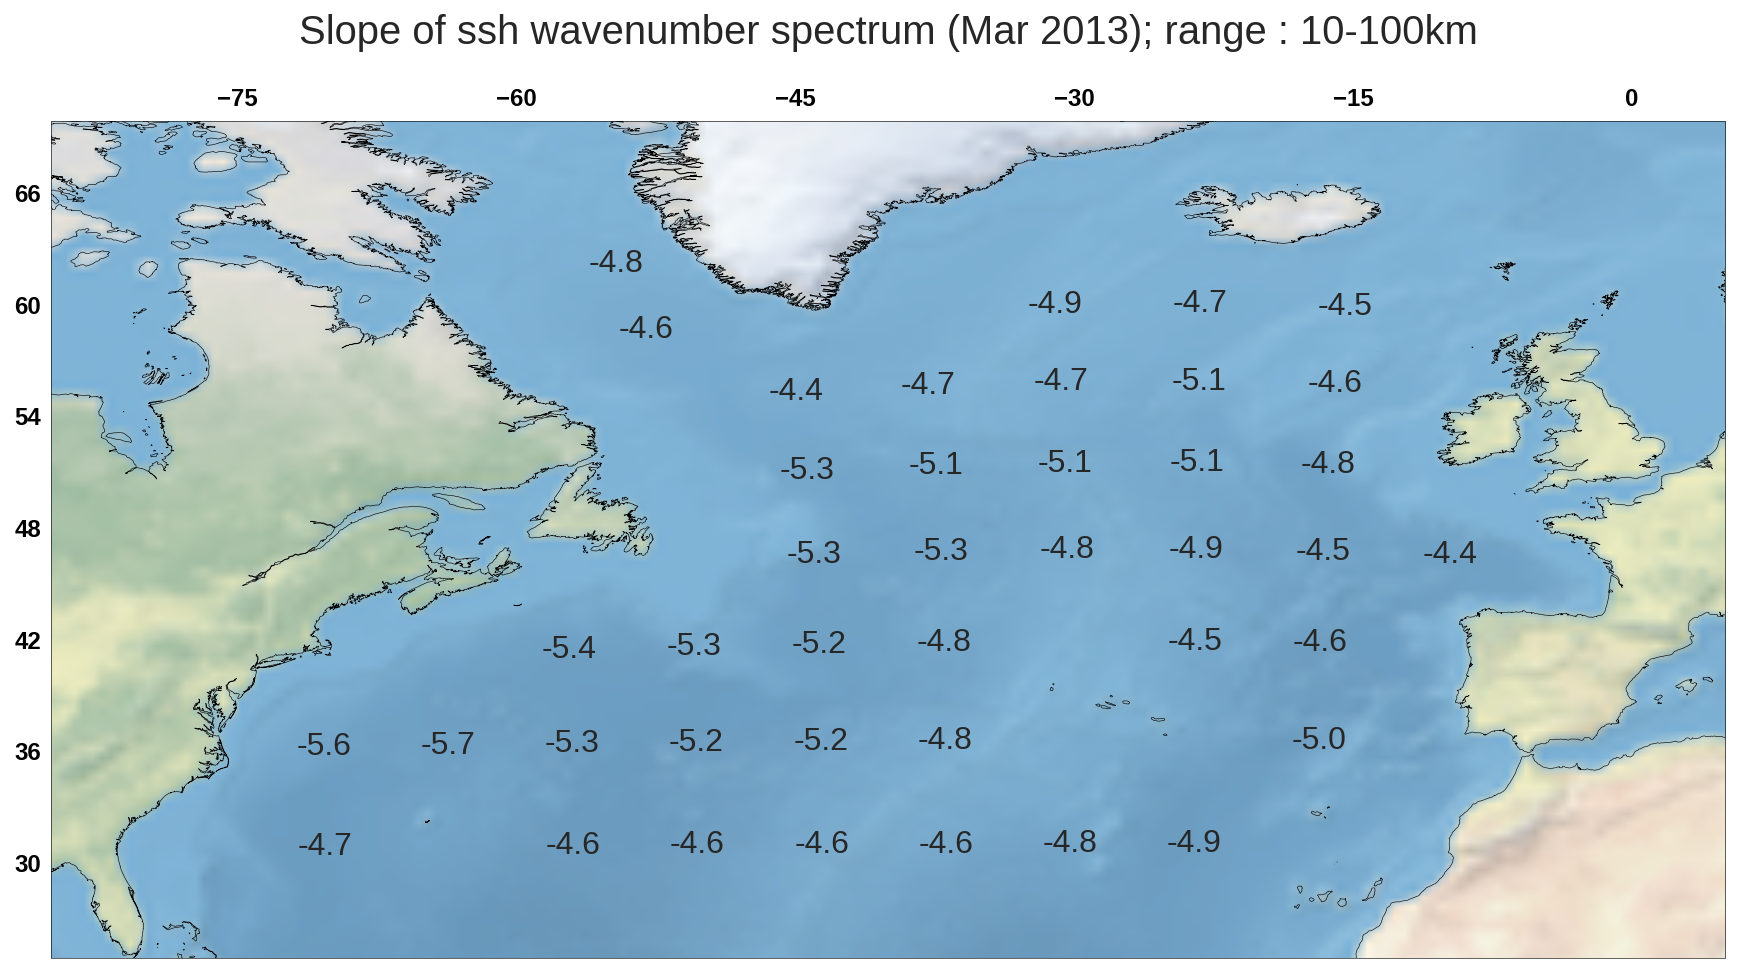

In [37]:
title = "Slope of ssh wavenumber spectrum (Mar 2013); range : 10-100km"
plot_boxes_attribute(rboxes,'str_ssh_slope_mar',fontsize=16,title=title)

